## Introduction to Dask

In [1]:
import time

def inc(x):
    time.sleep(1)
    return x + 1

def add(x, y):
    time.sleep(1)
    return x + y

In [2]:
x1 = inc(1)
x2 = inc(2)

In [8]:
%%time
z = add(x1, x2)

CPU times: user 1.3 ms, sys: 1.29 ms, total: 2.59 ms
Wall time: 1 s


In [3]:
from dask import delayed

x1 = delayed(inc)(1)
x2 = delayed(inc)(2)
z = delayed(add)(x1, x2)

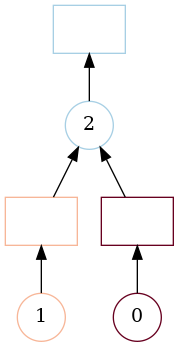

In [6]:
z.visualize(color="order")